In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from sspcab.sspcab_tf import SSPCAB

### Dataset

In [31]:
DATASET_DIR = '../datasets/mvtecad/hazelnut/'

In [32]:
#Size of our input images
SIZE = 128

from keras.preprocessing.image import ImageDataGenerator

batch_size = 32
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input',
    classes=['train']
    )

validation_generator = datagen.flow_from_directory(
    DATASET_DIR + 'test/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input',
    classes=['good']
    )

anomaly_generator = datagen.flow_from_directory(
    DATASET_DIR + 'test/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input',
    classes=['defective']
    )

Found 391 images belonging to 1 classes.
Found 40 images belonging to 1 classes.
Found 70 images belonging to 1 classes.


### Loading the model

In [33]:
MODEL_DIR = '../saved_models/basic/mvtec-hazelnut/'

model = tf.keras.models.load_model(MODEL_DIR + 'model.h5', custom_objects={'SSPCAB': SSPCAB})

### Creating the feature extractor

In [34]:
encoder_model = Sequential()

encoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3),  trainable=False, weights=model.layers[0].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same', strides=2))
encoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', trainable=False, weights=model.layers[2].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same', strides=2))
encoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', trainable=False, weights=model.layers[4].get_weights()))

### Creating the KDE model

In [35]:
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
encoded_images = encoder_model.predict(validation_generator)

# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder_model.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

#Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

2/2 [==============================] - 1s 251ms/step


### Evaluation the model

- Calculate density and reconstruction error to find their means values for good and anomaly images. 
- We use these mean and sigma to set thresholds.

In [36]:
def calc_density_and_recon_error(batch_images):
    density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):
        
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder_model.predict([[img]]) # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Flatten the compressed image
        density = kde.score_samples(encoded_img)[0] # get a density score for the new image
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)
        
    average_density = np.mean(np.array(density_list))  
    stdev_density = np.std(np.array(density_list)) 
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_density, stdev_density, average_recon_error, stdev_recon_error

In [37]:
normal_batch = validation_generator.next()[0]
anomaly_batch = anomaly_generator.next()[0]

normal_values = calc_density_and_recon_error(normal_batch)
anomaly_values = calc_density_and_recon_error(anomaly_batch)

print("Normal values: ", normal_values)
print("Anomaly values: ", anomaly_values)

1/1 [==============================] - 0s 73ms/step - loss: 0.0019 - mse: 0.0018 - mae: 0.0288
Normal values:  (11309.452953220762, 6.745581742084275e-06, 0.0012975007318140519, 0.00020862756159461567)
Anomaly values:  (11275.345135039528, 22.4259709108707, 0.0025637858216800997, 0.001938987973987517)


### Using the model for anomaly detection

- We use the thresholds to detect anomalies in the test set.

  - Density Threshold - Use a value close to the mean of the normal images.
  - Reconstruction Error Threshold - Use a value close to the mean of the normal images. (If the mean is too similar to the anomaly images, use a large value to indicate the only threshold is KDE)
  

In [38]:
density_threshold = 11300 # Good guess for density threshold, but might need to be adjusted for each dataset manually (normal_values[0] - normal_values[1])
reconstruction_error_threshold = 0.0021 # Good guess for reconstruction error threshold, but might need to be adjusted for each dataset manually (normal_values[2] + normal_values[3])

#### Checking anomalies

In [39]:
def check_anomaly(img_path):
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.Resampling.LANCZOS))
    
    original_img = img.copy()
    
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    
    encoded_img = encoder_model.predict([[img]]) 
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    
    density = kde.score_samples(encoded_img)[0] 

    reconstruction = model.predict([[img]])
    
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    reconstruction_loss = np.abs(img - reconstruction)
    reconstruction_loss = np.mean(reconstruction_loss, axis=3)[0]
    
    return (density < density_threshold or reconstruction_error > reconstruction_error_threshold), original_img, reconstruction_loss

In [40]:
import glob

""" If there is only one defective class, use this """
# defective_file_paths = glob.glob(DATASET_DIR + 'test/defective/*') 

""" If there are multiple defective classes, use this """
defective_file_paths = glob.glob(DATASET_DIR + 'test/defective/**/*')

normal_file_paths = glob.glob(DATASET_DIR + 'test/good/*') 

#### Preliminary Results

1/1 [==============================] - 0s 66ms/step - loss: 0.0014 - mse: 0.0013 - mae: 0.0295


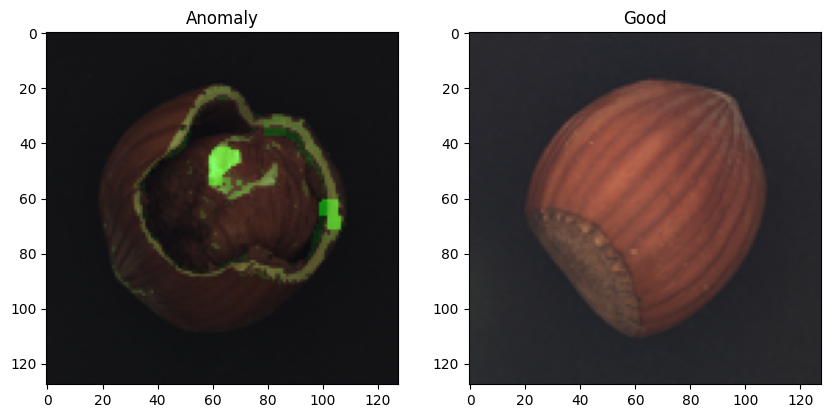

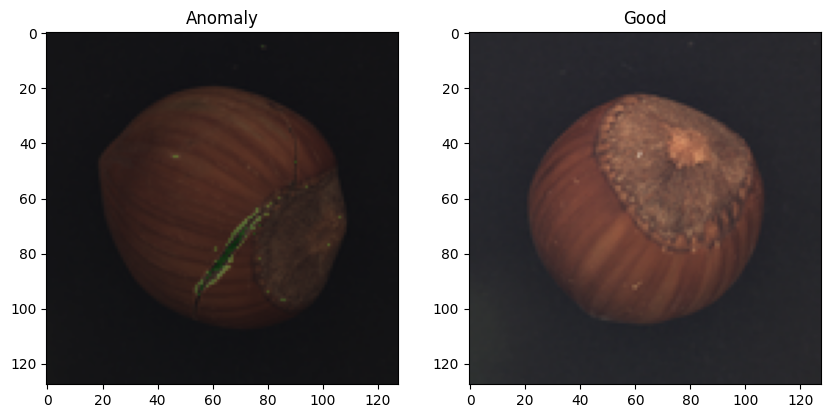

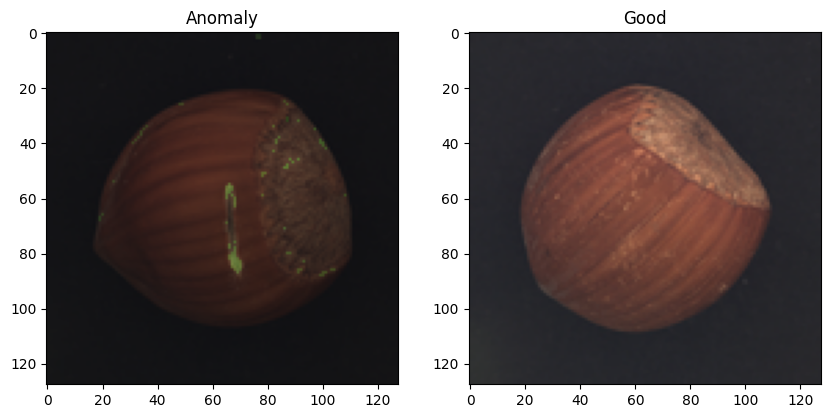

In [41]:
import PIL
import cv2

if not hasattr(PIL.Image, 'Resampling'):  # Pillow<9.0
    PIL.Image.Resampling = PIL.Image
    
for _ in range(3):
    # test images
    random_img = np.random.randint(0, len(defective_file_paths))
    is_anomaly, original_img, loss = check_anomaly(defective_file_paths[random_img])

    random_img2 = np.random.randint(0, len(normal_file_paths))
    is_anomaly2, original_img2, loss2 = check_anomaly(normal_file_paths[random_img2])

    fig, ax = plt.subplots(1,2, figsize=(10,10))

    ax[0].imshow(original_img)
    ax[0].set_title("Anomaly" if is_anomaly else "Good")
    
    # add a mask of the reconstruction loss as a heatmap
    mask = loss > 0.1
    overlay = original_img.copy()
    overlay[mask] = [0, 255, 0]

    new_overlay = cv2.morphologyEx(overlay, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))

    # remove unaffected pixels
    new_overlay[~mask] = 0
    
    ax[0].imshow(new_overlay, alpha=0.5, cmap='binary', vmin=0, vmax=1)

    ax[1].imshow(original_img2)
    ax[1].set_title("Anomaly" if is_anomaly2 else "Good")

### Calculating AUROC

In [ ]:
def roc_auc_score(y_true, y_pred):
    return np.mean(np.array(y_true) == np.array(y_pred))

def calc_auroc():
    y_true = []
    y_pred = []
    for f in defective_file_paths:
        is_anomaly, _ = check_anomaly(f)
        y_true.append(1)
        y_pred.append(is_anomaly)
        
    for f in normal_file_paths:
        is_anomaly, _ = check_anomaly(f)
        y_true.append(0)
        y_pred.append(is_anomaly)
        
    return roc_auc_score(y_true, y_pred)

print("AUROC: ", calc_auroc())